Code based on: https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Flatten, Dense, Reshape
from keras import backend as K
import matplotlib.pyplot as plt
import os
%matplotlib inline

Using TensorFlow backend.


# Data (MNIST)
Import the MNIST dataset, normalise and reshape it.

In [3]:
# Import the mnist data set only
from keras.datasets import mnist
# Numpy
import numpy as np

# Load the data set. Takes around 30 sec...
(x_train, _), (x_test, _) = mnist.load_data()

# size of the image and chanels. 28x28 pixels and only grayscale (1 chanel)
img_rows, img_cols, chns = 28, 28, 1

# Treat as float 32. Book suggests that if we experience memory issues, we should think about float16
# Dividing by 255 is to normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# The ordering of the dimensions in the inputs. 
#  - channels_last corresponds to inputs with shape (batch, height, width, channels)
#  - channels_first corresponds to inputs with shape (batch, channels, height, width) 
# batch is number of elements in the batch (rows)
# chns = number of chanels (1 in our case)
# img_rows = height
# img_cols = width
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

11493376/11490434 [==============================] - 28s 2us/step


### Adding noise
We obtain a noisy version of our data by adding Gaussian (normal) noise to each pixel, and clipping pixel values between 0 and 1.

In [4]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Let's visualise some examples from the original test set as well as their noisy version.

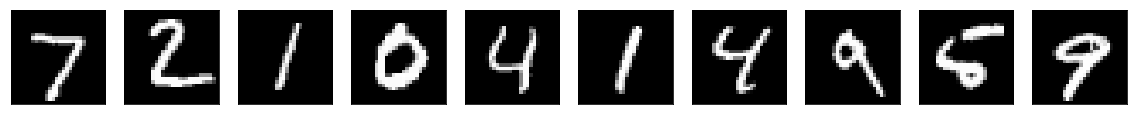

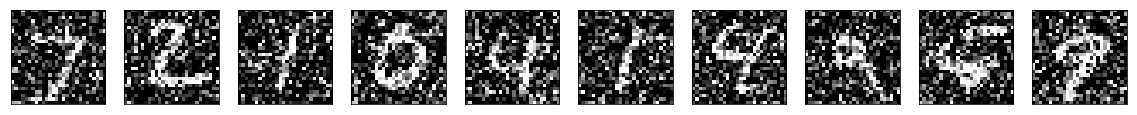

In [5]:
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plot_examples(x_test)
plot_examples(x_test_noisy)

# Model architecture & settings

For the encoder we will use convolutional layers and Max-Pooling (to down-sample the image), followed by a Dense layer. This gives a hidden "code" of 128 dimensions. For the decoder we use a Dense layer to upscale to the same dimension before convolutional layers and UpSampling. We also include Batch Normalization, which significantly speeds up training.

More precisely, for the encoder we will use the following architecture:
* Convolutional layer
* MaxPooling
* Batch Normalization
* Convolutional layer
* MaxPooling
* Batch Normalization
* Dense layer

From this we obtain a 128-dimensional encoded representation, this is the "code" of the autoencoder.

The decoder will have the following architecture:
* Dense layer (to reshape/upsample to a suitable representation for the next convolutional layer)
* Convolutional layer
* UpSampling
* Batch Normalization
* Convolutional layer
* UpSampling
* Batch Normalization
* Convolutional layer (this layer should generate ouput images, of the same format as the input of the encoder)

All convolutional layers (except for the output layer) will have 32 filters (feature maps), a kernel size of 3x3, strides of 1x1, "ReLU" activations and "same" padding. All MaxPooling and UpSampling operations will have size 2x2. To connect a convolutional layer after a Dense layer, use a Reshape layer to transform the data to the right shape for convolutions.

The final convolutional layer should produce images in the same format as the input. It will have a kernel size of 3x3, and use "same" padding. Think of a suitable activation, and the right number of filters.

Optional: output a summary of the architecture.

Compile the model to use the "adam" optimizer, with a suitable loss function.

In [ ]:
# === add code here

# Training the model
Train the model (using stochastic gradient descent) with given batch size, for given number of epochs. We split of 1/12-th of the data (5,000 of the 60,000 samples) as validation data, such that we can use the validation accuracy for hyperparameter tuning. Since the model includes batch normalization, we don't need to train for many epochs to achieve reasonable results.

Note that we use the noisy data as input and the original data as target, such that the model learns to denoise the data.

In [ ]:
batch_size = 100
epochs = 10

autoencoder.fit(x_train_noisy, x_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=1/12)

# Evaluating the model
We cannot use an accuracy measure here like in supervised learning, since there are no target labels. We can compute a loss value for the test set, but this doesn't provide an intuitive result. Therefore we will also inspect a few reconstructions visually. First we use the autoencoder to denoise the test set, then we visualise a few examples (the original images, the noisy versions, and their denoised reconstructions).

In [ ]:
test_loss = autoencoder.evaluate(x_test_noisy, x_test, batch_size=batch_size)
print("Test loss:", test_loss)

x_test_reconstr = autoencoder.predict(x_test_noisy, batch_size=batch_size)

plot_examples(x_test)
plot_examples(x_test_noisy)
plot_examples(x_test_reconstr)

# Saving the model
We save the model to a .h5 file, such that we can load it later in other notebooks.

In [ ]:
autoencoder.save(os.path.join("models", "dae_mnist.h5"))